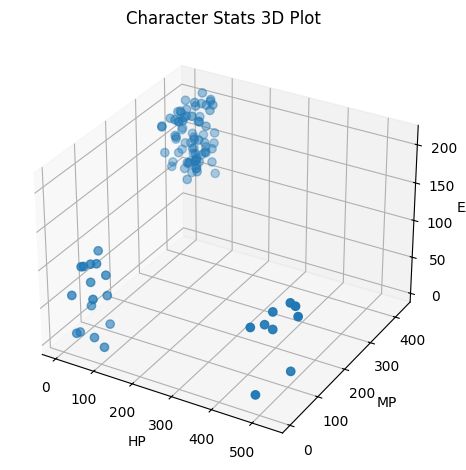

📁 3D画像保存: after_update_scatter.png


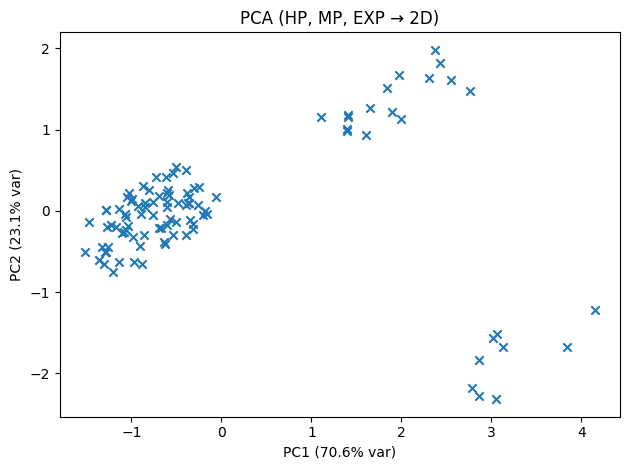

📁 PCA画像保存: pca_2d.png
Explained variance ratio: [0.70629312 0.23148289 0.062224  ]


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
cit-db-2025-game.db を読み込み:
  1) （任意）役割バイアスUPDATEを一度だけ適用
  2) HP/MP/EXP を3D散布図で表示 & PNG保存
  3) PCA(SVD)で2次元に次元削減して表示 & PNG保存

Jupyterノート内に埋め込み表示されるよう inline バックエンドを強制します。
"""

import os
import sqlite3
import numpy as np
import matplotlib

# ── Notebook 埋め込み表示（外部ウィンドウを開かない）
try:
    matplotlib.use("module://matplotlib_inline.backend_inline")
except Exception:
    pass

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ===== 設定 =====
DB_PATH      = "cit-db-2025-game.db"   # 必要に応じて変更
IMG_3D_PATH  = "after_update_scatter.png"
IMG_PCA_PATH = "pca_2d.png"
APPLY_UPDATE = False   # ← True にすると偏りUPDATEを一度だけ適用

# ===== UPDATE（役割で偏らせる：一度だけ）=====
CREATE_FLAG_SQL = """
CREATE TABLE IF NOT EXISTS __update_flags__(
    name TEXT PRIMARY KEY,
    applied_at TEXT DEFAULT (datetime('now'))
);
"""
CHECK_FLAG_SQL = "SELECT 1 FROM __update_flags__ WHERE name='role_bias_v1' LIMIT 1;"
SET_FLAG_SQL   = "INSERT INTO __update_flags__(name) VALUES ('role_bias_v1');"
ROLE_UPDATE_SQLS = [
    # 魔法型 doraemon：MPとEXPを上げる
    """UPDATE "character"
       SET MP = MP + 30, EXP = EXP + 10
       WHERE character_name='doraemon';""",
    # 物理型 bikkuriko：HPを上げる
    """UPDATE "character"
       SET HP = HP + 40
       WHERE character_name='bikkuriko';"""
]

def apply_role_bias_once(conn):
    cur = conn.cursor()
    cur.execute(CREATE_FLAG_SQL)
    if cur.execute(CHECK_FLAG_SQL).fetchone():
        print("※ 役割バイアスUPDATEは適用済み（スキップ）")
        return False
    for sql in ROLE_UPDATE_SQLS:
        cur.execute(sql)
    cur.execute(SET_FLAG_SQL)
    conn.commit()
    print("✅ 役割バイアスUPDATEを適用しました")
    return True

# ===== データ取得 =====
def load_stats(conn):
    cur = conn.cursor()
    cur.execute('SELECT HP, MP, EXP FROM "character";')
    rows = cur.fetchall()
    if not rows:
        raise RuntimeError("characterテーブルが空です。")
    return np.array(rows, dtype=float)

# ===== 3D散布図 =====
def plot_3d(X, save_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=36, marker="o")
    ax.set_xlabel("HP"); ax.set_ylabel("MP"); ax.set_zlabel("EXP")
    ax.set_title("Character Stats 3D Plot")
    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.show()
    print(f"📁 3D画像保存: {save_path}")

# ===== PCA（NumPy SVD）→ 2D散布 =====
def plot_pca2(X, save_path):
    # 標準化
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=1); sigma[sigma == 0] = 1.0
    Xz = (X - mu) / sigma
    # SVD
    U, S, Vt = np.linalg.svd(Xz, full_matrices=False)
    eigvals = (S**2) / (Xz.shape[0] - 1)
    ratio = eigvals / eigvals.sum()
    # 射影（PC1, PC2）
    W2 = Vt[:2].T           # (3,2)
    Z2 = Xz @ W2            # (n,2)
    # プロット
    plt.figure()
    plt.scatter(Z2[:, 0], Z2[:, 1], s=36, marker="x")
    plt.xlabel(f"PC1 ({ratio[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({ratio[1]*100:.1f}% var)")
    plt.title("PCA (HP, MP, EXP → 2D)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"📁 PCA画像保存: {save_path}")
    print("Explained variance ratio:", ratio[:3])

def main():
    if not os.path.exists(DB_PATH):
        raise FileNotFoundError(f"DBが見つかりません: {DB_PATH}")

    with sqlite3.connect(DB_PATH) as conn:
        if APPLY_UPDATE:
            apply_role_bias_once(conn)
        X = load_stats(conn)

    # 3D & PCA
    plot_3d(X, IMG_3D_PATH)
    plot_pca2(X, IMG_PCA_PATH)

if __name__ == "__main__":
    main()
